# Least squares reverse time migration (LSRTM) of the 2D acoustic Marmousi 2 model

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

from pyseis.wave_equations import acoustic_isotropic
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion

import sys
sys.path.append("../")
import plotting

MARMOUSI_PATH = '../Marmousi2_elastic.npz'

## Load and plot marmousi 

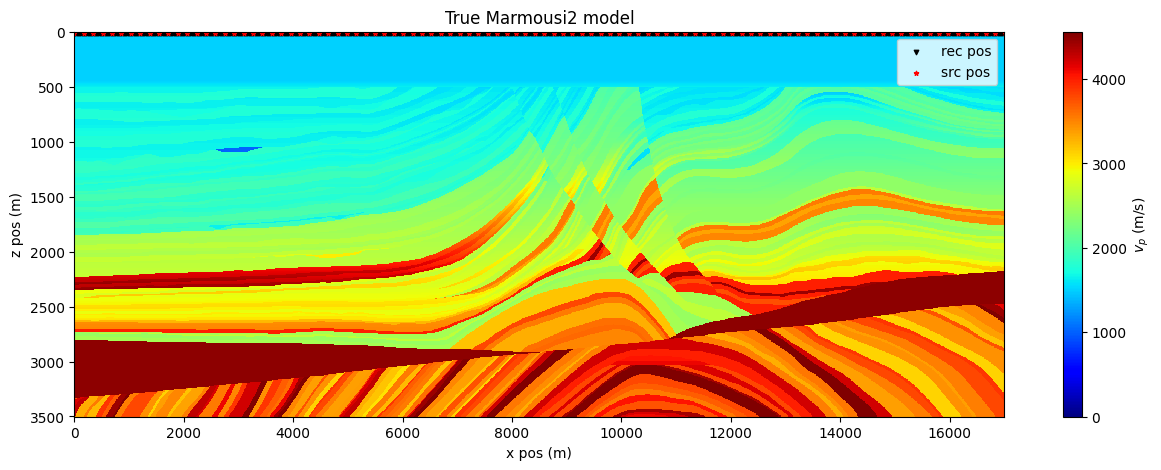

In [2]:
# load marmousi model
marm_npz = np.load(MARMOUSI_PATH)
true_model = marm_npz['model'][0] # window out p-wave velocity
model_sampling = tuple(marm_npz['model_sampling'])

# create source and receiver geometry
n_rec = true_model.shape[0]//2
x_rec = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_rec)
z_rec = 10.0 * np.ones_like(x_rec) 
recs = np.array([x_rec, z_rec]).T

n_src = 100
x_src = np.linspace(0.0,model_sampling[0]*true_model.shape[0],num=n_src)
z_src = 10.0 * np.ones_like(x_src) 
srcs = np.array([x_src, z_src]).T

plotting.plot_model(true_model,
           title='True Marmousi2 model', 
           cbar=True,
           src_locations=srcs,
           rec_locations=recs)

## Initialize acoustic wave equation

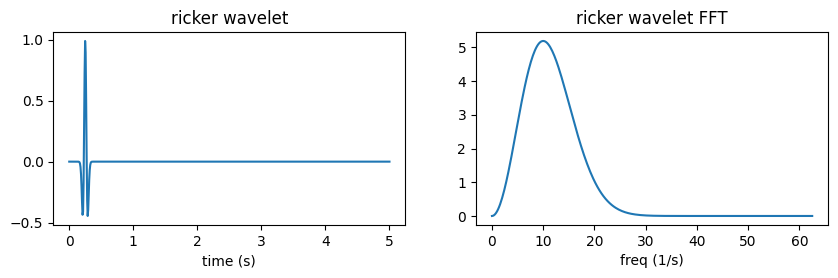

In [3]:
# make a Ricker wavelet
n_t = 626
d_t = 0.008
dom_freq = 10.0
delay= 0.25
ricker = Acoustic2D.AcousticIsotropicRicker2D(n_t, d_t, dom_freq, delay).arr

plotting.plot_wavelet(ricker,d_t,title='ricker wavelet')

In [4]:
# make 2d acoustic wave equation solver
acoustic_2d = acoustic_isotropic.AcousticIsotropic2D(
  model=true_model,
  model_sampling=model_sampling,
  model_padding=(50, 50),
  wavelet=ricker,
  d_t=d_t,
  src_locations=srcs,
  rec_locations=recs,
  gpus=[0,1,2,3])

## Make true image and migration velocity

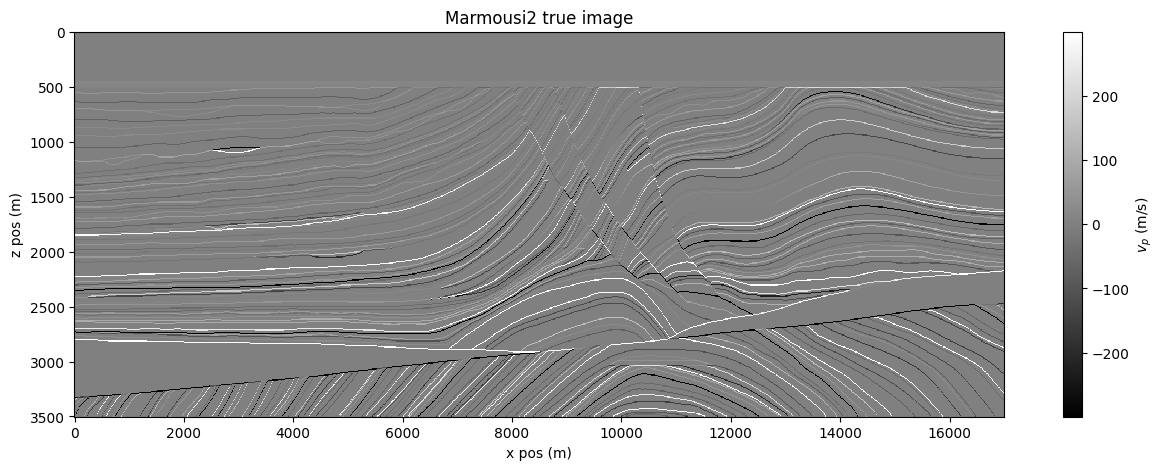

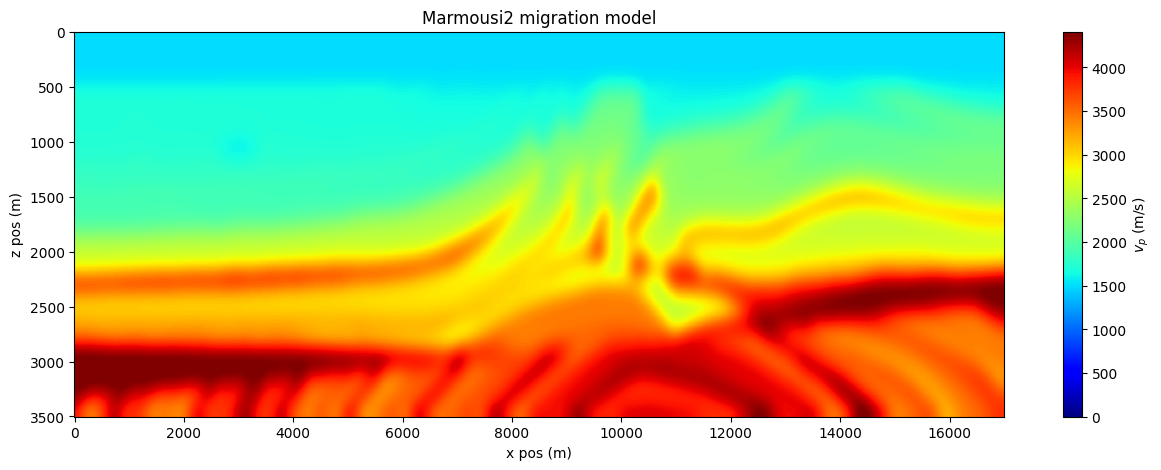

In [20]:
# make linear model
lin_model = np.gradient(true_model, axis=-1)
# make migration velocity
mig_vel = ndimage.gaussian_filter(true_model,sigma=(20,20))

pclip=98
clip=np.percentile(np.abs(lin_model),pclip)
plotting.plot_model(lin_model,
           title='Marmousi2 true image', 
           cmap='gray',
           cbar=True,
           vlims=[-clip,clip])

plotting.plot_model(mig_vel,
           title='Marmousi2 migration model', 
           cbar=True)

## Make linear data

CPU times: user 5min 21s, sys: 2min 39s, total: 8min 1s
Wall time: 1min 44s


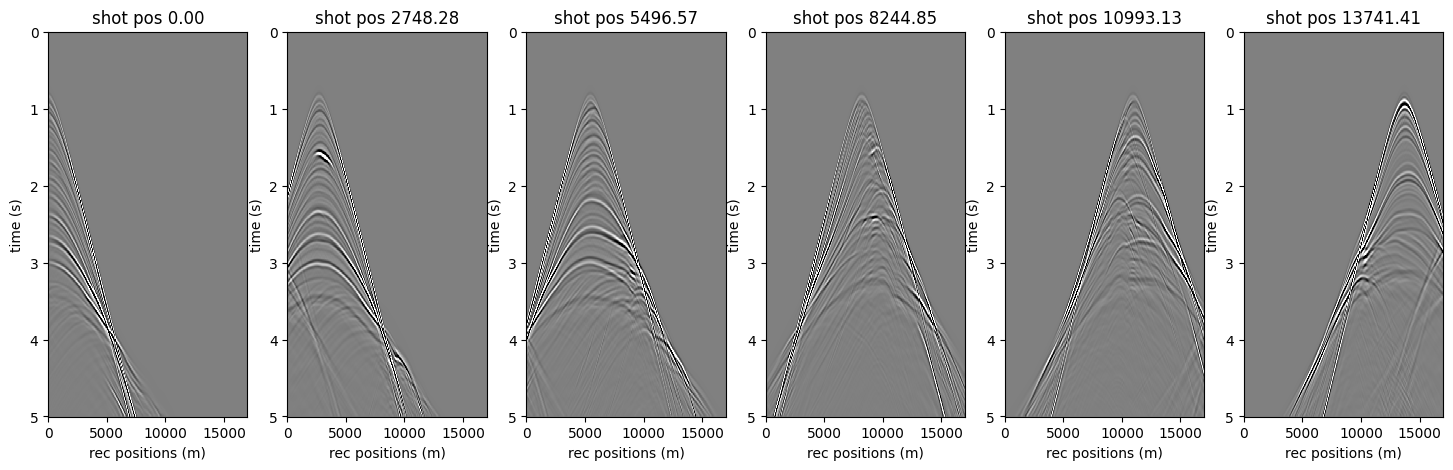

In [6]:
%%time
lin_data = acoustic_2d.jacobian(lin_model, mig_vel)

plotting.plot_data(lin_data,
          d_t,
          src_locations=x_src,
          rec_locations=x_rec)

## Run least sqaures reverse time migration

In [7]:
lsrtm_prob = inversion.Lsrtm(wave_eq_solver=acoustic_2d,
                             linear_data=lin_data,
                             migration_model=mig_vel,
                             num_iter=20,
                             iterations_per_save=5)

In [ ]:
%%time

history = lsrtm_prob.run()

In [12]:
history.keys()

dict_keys(['inv_mod', 'gradient', 'model', 'residual', 'obj'])

## Plot objective function over iterations

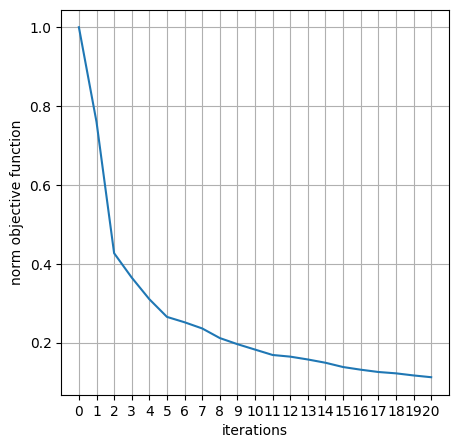

In [13]:
obj_func = history['obj']

fig, ax = plt.subplots(1,figsize=(5,5))
ax.plot(obj_func/obj_func.max())
_ = ax.set_xlabel('iterations')
_ = ax.set_ylabel('norm objective function')
_ = ax.set_xticks(np.arange(len(obj_func)))
ax.grid()

## Plot final image

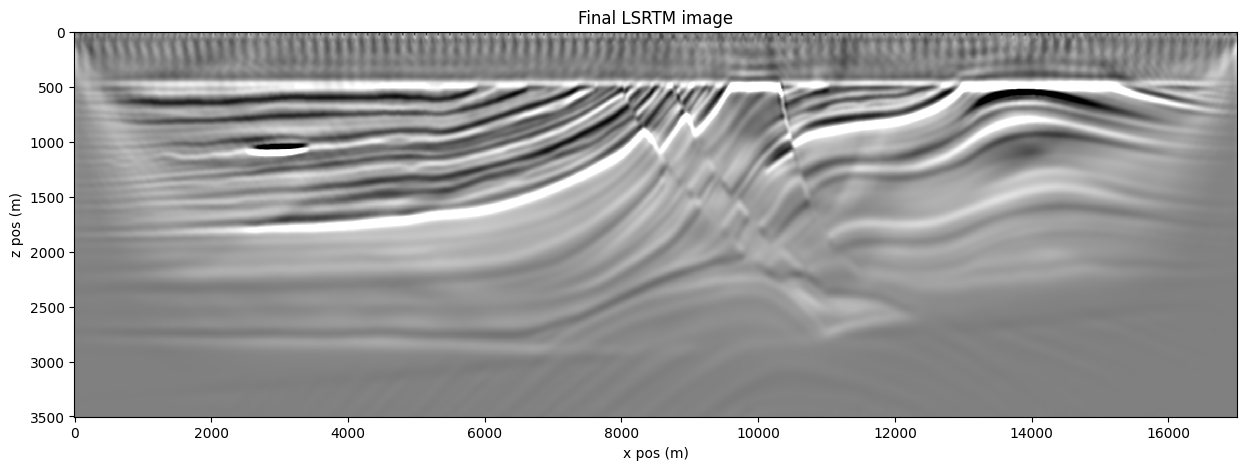

In [29]:
pclip=98
clip=np.percentile(np.abs(history['inv_mod']),pclip)
plotting.plot_model(history['inv_mod'],
           title='Final LSRTM image',
           cmap='gray',
           vlims=[-clip,clip])

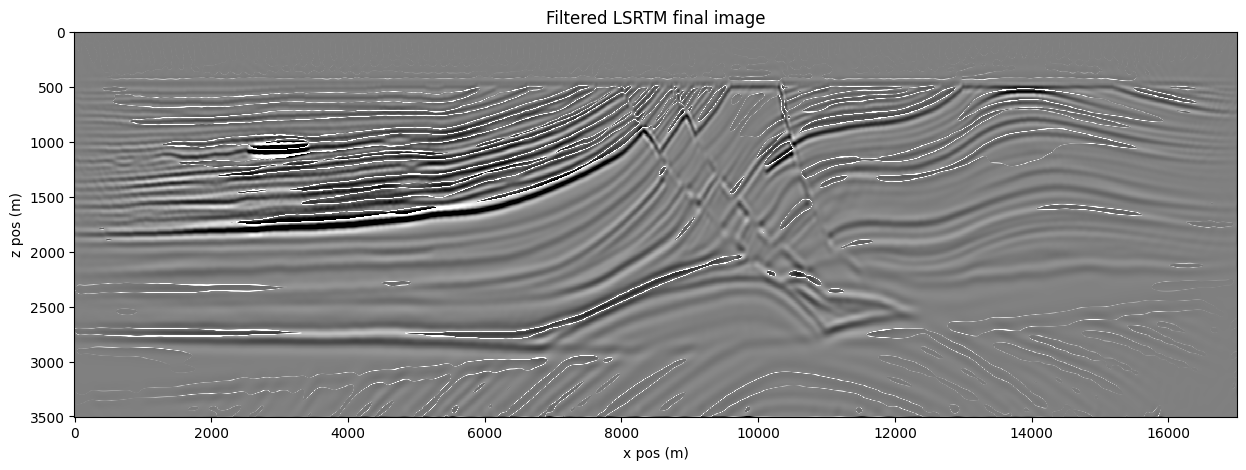

In [28]:
# apply laplace filter and apply tpow
img_filtered = np.arange(np.abs(history['inv_mod']).shape[-1])**2 * ndimage.laplace(np.abs(history['inv_mod']))

clip = np.percentile(abs(img_filtered),98)
plotting.plot_model(img_filtered,
           title='Filtered LSRTM final image', 
           cmap='gray',
           vlims=[-clip,clip])